# Two Simple Graph Classifiers

In [127]:
import dgl
from dgl.data import MiniGCDataset
from dgl.nn.pytorch import GraphConv, SAGEConv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import networkx as nx
import matplotlib.pyplot as plt

Indegrees: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])


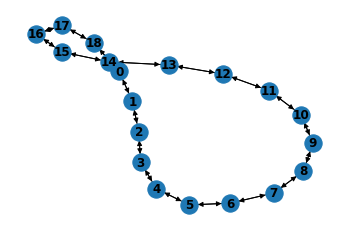

In [135]:
data = MiniGCDataset(100, 10, 20)
G = data[4][0]
plt.subplot()
nx.draw(G.to_networkx(), with_labels=True, font_weight='bold')
print("Indegrees:", G.in_degrees())

In [114]:
def get_dataloader_and_testset(train_num, test_num, min_nodes, max_nodes):
    
    trainset = MiniGCDataset(train_num, min_nodes, max_nodes)
    testset = MiniGCDataset(test_num, min_nodes, max_nodes)
    
    def collate(samples):
        graphs, labels = map(list, zip(*samples))
        batched_graph = dgl.batch(graphs)
        return batched_graph, torch.tensor(labels)
    
    data_loader = DataLoader(trainset, batch_size=32, shuffle=True, collate_fn=collate)
    
    return data_loader, testset
    

In [115]:
def train(model, loss_func, optimizer, num_epochs, data_loader):
    
    model.train()
    
    epoch_losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for iter, (bg, label) in enumerate(data_loader):
            prediction = model(bg)
            loss = loss_func(prediction, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.detach().item()
        epoch_loss /= (iter + 1)
        if epoch % 10 == 0:
            print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
        epoch_losses.append(epoch_loss)
        
    return model, epoch_losses


In [116]:
def plot_loss_graph(losses):
    plt.title('cross entropy averaged over minibatches')
    plt.plot(losses)
    plt.show()

In [ ]:
def evaluate_model(model, testset):
    model.eval()
    
    test_X, test_Y = map(list, zip(*testset))
    test_bg = dgl.batch(test_X)
    test_Y = torch.tensor(test_Y).float().view(-1, 1)
    probs_Y = torch.softmax(model(test_bg), 1)
    sampled_Y = torch.multinomial(probs_Y, 1)
    argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
    print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
        (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
    print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
        (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

# Graph Conv

In [118]:
class GraphConv_Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(GraphConv_Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)
        
    def forward(self, g):
        h = g.in_degrees().view(-1, 1).float() # initial node feature will be the the indegree
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

Epoch 0, loss 1.9878
Epoch 10, loss 1.3033
Epoch 20, loss 0.8208
Epoch 30, loss 0.6977
Epoch 40, loss 0.7043


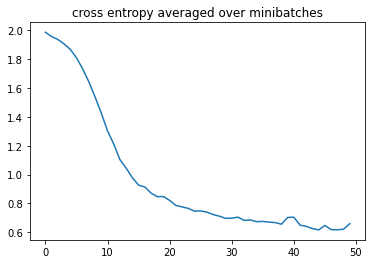

Accuracy of sampled predictions on the test set: 60.5000%
Accuracy of argmax predictions on the test set: 73.500000%


In [119]:
dataloader, testset = get_dataloader_and_testset(600, 200, 10, 20)

graph_model = GraphConv_Classifier(1, 256, testset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(graph_model.parameters(), lr=0.001)

graph_model, losses = train(graph_model, loss_func, optimizer, 50, dataloader)

plot_loss_graph(losses)
evaluate_model(graph_model, testset)

# GraphSAGE

In [124]:
class SAGEConv_Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes, agr):
        super(SAGEConv_Classifier, self).__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim, agr)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim, agr)
        self.classify = nn.Linear(hidden_dim, n_classes)
        
    def forward(self, g):
        h = g.in_degrees().view(-1, 1).float() # # initial node feature will be the the indegree
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

Epoch 0, loss 1.6012
Epoch 10, loss 0.1576
Epoch 20, loss 0.1472
Epoch 30, loss 0.1410
Epoch 40, loss 0.1397


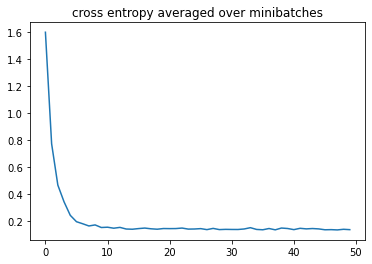

Accuracy of sampled predictions on the test set: 91.0000%
Accuracy of argmax predictions on the test set: 93.000000%


In [126]:
dataloader, testset = get_dataloader_and_testset(600, 200, 10, 20)

sage_model = SAGEConv_Classifier(1, 256, testset.num_classes, 'lstm')
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(sage_model.parameters(), lr=0.001)

sage_model, losses = train(sage_model, loss_func, optimizer, 50, dataloader)

plot_loss_graph(losses)
evaluate_model(sage_model, testset)